# Experiment 2: Content
## How sensitive is the T5-ASP model to changes in gazetteer content quality and quantity?

### Datasets

In [1]:
import json

with open("/home/loebbert/projects/thesis/data/mlowner/lowner_train.json",
          encoding="utf-8") as file:
    lowner_train = json.load(file)

with open("/home/loebbert/projects/thesis/data/mlowner/lowner_dev.json",
          encoding="utf-8") as file:
    lowner_dev = json.load(file)

with open("/home/loebbert/projects/thesis/data/mlowner/lowner_test.json",
          encoding="utf-8") as file:
    lowner_test = json.load(file)

with open("/home/loebbert/projects/thesis/data/mlowner/lowner_gazetteer.json",
          encoding="utf-8") as file:
    lowner_gazetteer = json.load(file)

with open(
        "/home/loebbert/projects/thesis/data/multiconer/multiconer_test.json",
        encoding="utf-8") as file:
    multiconer_test = json.load(file)

with open("/home/loebbert/projects/thesis/data/mlowner/lowner_types.json", encoding="utf-8") as file:
    types = json.load(file)["entities"]


### Scenario
Painstakingly labeled amount of data:
- 100% Lowner train + dev dataset
- 12000 items of multiconer-test (2000 each): uniform distribution of labels
- parts of lowner gazetteer: top-5 similarity sampled by using parts of multiconer-test -> quick gazetteers

#### Multiconer + gazetteer data sampling

In [2]:
from typing import List
from collections import defaultdict, Counter
import random
import pandas as pd

def per_type_uniform_sampling(dataset: List[dict], types: List[str], sample_size: int):
    # count entities per doc
    doc_entity_count = []
    for doc in dataset:
        doc_entity_count.append({
            "doc_id": doc["doc_id"],
            **Counter([ent["type"] for ent in doc["entities"]])
        })
    count_df = pd.DataFrame.from_records(doc_entity_count).fillna(0)

    # get types
    type_to_ids = {
        t: frozenset(count_df[count_df[t]>0]["doc_id"].tolist())
        for t in types
    }
    type_count = defaultdict(int)
    sampled_ids = set()

    type_set = list(types)
    random.shuffle(type_set)

    for typ in type_set:
        done_sampling = False
        while not done_sampling:
            if type_count[typ] >= sample_size:
                done_sampling = True
                break
            sample_set = list(type_to_ids[typ].difference(sampled_ids))
            select_id = random.choice(sample_set)
            sampled_ids.add(select_id)
            entity_count = count_df[count_df["doc_id"]==select_id].iloc[0]
            for t in types:
                type_count[t]+=entity_count[t]

    return [doc for doc in dataset if doc["doc_id"] in sampled_ids], type_count


In [3]:
import random
random.seed(1)
docs1, type_count1 = per_type_uniform_sampling(
    multiconer_test, types, 2000)

random.seed(2)
docs2, type_count2 = per_type_uniform_sampling(
    multiconer_test, types, 2000)

random.seed(3)
docs3, type_count3 = per_type_uniform_sampling(multiconer_test, types, 2000)


In [4]:
type_count1, type_count2, type_count3

(defaultdict(int,
             {'corporation': 2256.0,
              'location': 2104.0,
              'group': 2001.0,
              'person': 2556.0,
              'creative-work': 2047.0,
              'product': 2056.0}),
 defaultdict(int,
             {'corporation': 2277.0,
              'location': 2000.0,
              'group': 2132.0,
              'person': 2584.0,
              'creative-work': 2075.0,
              'product': 2017.0}),
 defaultdict(int,
             {'location': 2297.0,
              'group': 2000.0,
              'corporation': 2205.0,
              'person': 2504.0,
              'creative-work': 2048.0,
              'product': 2033.0}))

In [5]:
docs1_set = set([doc["doc_id"] for doc in docs1])
docs2_set = set([doc["doc_id"] for doc in docs2])
docs3_set = set([doc["doc_id"] for doc in docs3])

docs1_docs2_overlap = docs1_set.intersection(docs2_set)
docs1_docs3_overlap = docs1_set.intersection(docs3_set)
docs2_docs3_overlap = docs2_set.intersection(docs3_set)

res = {
    "docs1_to_docs2": len(docs1_docs2_overlap) / len(docs1_set),
    "docs2_to_docs1": len(docs1_docs2_overlap) / len(docs2_set),
    "docs1_to_docs3": len(docs1_docs3_overlap) / len(docs1_set),
    "docs3_to_docs1": len(docs1_docs3_overlap) / len(docs3_set),
    "docs2_to_docs3": len(docs2_docs3_overlap) / len(docs2_set),
    "docs3_to_docs2": len(docs2_docs3_overlap) / len(docs3_set),
}
res, len(docs1_set), len(docs2_set), len(docs3_set)

({'docs1_to_docs2': 0.05031511519785102,
  'docs2_to_docs1': 0.05076089222430686,
  'docs1_to_docs3': 0.05114164686434549,
  'docs3_to_docs1': 0.0509416486569929,
  'docs2_to_docs3': 0.04857202418178028,
  'docs3_to_docs2': 0.04795718843264382},
 9679,
 9594,
 9717)

Expected Entity Coverage Ratio: 100%|██████████| 49/49 [00:00<00:00, 452689.20it/s]


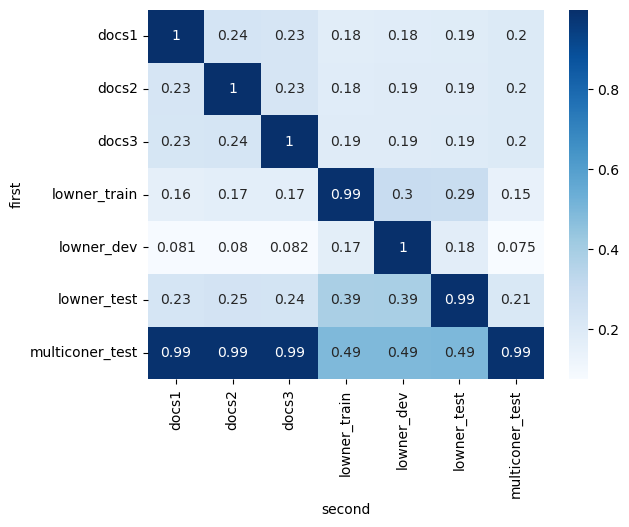

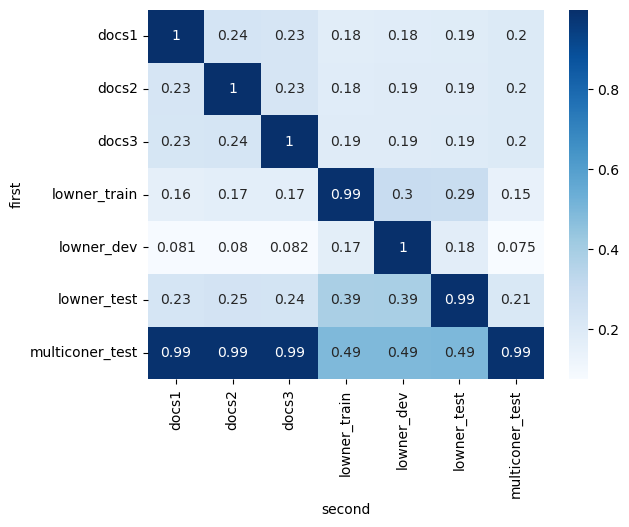

In [8]:
from data_metrics.entity_coverage_ratio import confusion_matrix_expected_entity_coverage_ratio
from data_metrics.utils import visualize_confusion_matrix

cm = confusion_matrix_expected_entity_coverage_ratio([
    lowner_train, lowner_dev, lowner_test, docs1, docs2, docs3, multiconer_test
], [
    "lowner_train", "lowner_dev", "lowner_test", "docs1", "docs2", "docs3",
    "multiconer_test"
])
visualize_confusion_matrix(cm, "expected_entity_coverage_ratio")

### Scenario
Unfortunately, you made labelling mistakes and the data contains spelling errors as well
- Was not that bad, but you noticed it (possible scenarios: 5%, 10%, 15% - https://arxiv.org/abs/2103.14749)
- Data augmentation to introduce labelling errors: based on error types
    - Wrong span, correct label: if len == 1, increase left or right, else increase/decrease left or right (depending on sentence length)
    - wrong labels, correct span: randomize label
    - not labeled: remove label
    - wrong label, wrong span: Take unlabeled noun phrases and randomly choose a label
- Data augmentation to introduce spelling/typing errors: https://github.com/makcedward/nlpaug